In [74]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

In [75]:
data, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

In [83]:
def parse_review(dataset):
    reviews = []
    labels = []

    for review, label in dataset:
        img = Image.fromarray(review.numpy())
        img_reshaped = img.resize((224,224))
        reviews.append(np.array(img_reshaped, dtype=np.float64))
        labels.append(label.numpy())

    reviews= np.array(reviews, dtype=np.float64)
    labels = np.array(labels, dtype=np.float32)
    return reviews, labels

In [84]:
def split_dataset(images, labels, train_split = 0.75, shuffle = True):
    train_images, train_labels,  validation_images, validation_labels = train_test_split(images, labels , train_size= train_split, stratify=labels, shuffle=True)
    return train_images, train_labels,  validation_images, validation_labels

In [85]:
def print_classes_lables(collection):
    element, count = np.unique( collection, return_counts=True)
    print(f'unique classes: {element} \n frequency: {count}\n')

In [86]:
full_data = data['train']

In [87]:
img, label = parse_review(full_data)

train_x, val_x, train_y, val_y = split_dataset(images=img,
                                                labels=label,
                                                train_split=0.75,
                                                shuffle=True)


In [88]:
print(f' train images: {train_x.shape}')
print(f' train lables: {train_y.shape}')
print_classes_lables(train_y)


print(f' val images: {val_x.shape}')
print(f' val lables: {val_y.shape}')
print_classes_lables(val_y)

 train images: (2752, 224, 224, 3)
 train lables: (2752,)
unique classes: [0. 1. 2. 3. 4.] 
 frequency: [673 475 599 524 481]

 val images: (918, 224, 224, 3)
 val lables: (918,)
unique classes: [0. 1. 2. 3. 4.] 
 frequency: [225 158 200 175 160]



In [89]:
def get_pre_trained_model(input_shape = None):

    # block_11_add for MobilenetV2
    # mixed7 for inceptionV3

    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
        input_shape= input_shape,
        include_top= False,
        weights='imagenet',
    )


    # pre_trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    #     input_shape= input_shape,
    #     include_top= False,
    #     weights='imagenet',
    # )

    # pre_trained_model = tf.keras.applications.resnet50.ResNet50(
    #     input_shape= input_shape,
    #     include_top= False,
    #     weights='imagenet',
    # )

    # pre_trained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    #     input_shape= input_shape,
    #     include_top= False,
    #     weights='imagenet',
    # )


    # set layers trainable to false
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # print(pre_trained_model.summary())

    return pre_trained_model

In [90]:
def get_layer_output( pre_trained_model, layer_name):
    selected_layer = pre_trained_model.get_layer(layer_name)
    output = selected_layer.output
    return output


In [92]:
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                                horizontal_flip=True,
                                                                vertical_flip=False,
                                                                width_shift_range=0.3,
                                                                fill_mode='nearest')

validation_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)


In [104]:
train_images = train_img_gen.flow(x=train_x,
                                  y=train_y,
                                  batch_size=64)

validation_images = validation_img_gen.flow(x = val_x,
                                            y = val_y,
                                            batch_size=64)

In [105]:
check_point_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath= 'best_model_as_per_val_accuracy.h5',# path to save the model if the check point matches
    save_best_only= True,
    monitor= 'val_accuracy', # check if the it is logged as val_acc or val_accuracy
    mode= 'auto' # options {min, max, auto}
)

In [106]:

pre_trained_model = get_pre_trained_model(input_shape=(224,224,3))
output_layer = get_layer_output(pre_trained_model, layer_name='mixed7')

x = tf.keras.layers.Flatten()(output_layer)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs = pre_trained_model.input, outputs=x)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model.compile(loss=loss, optimizer= optimiser,
              metrics=[
                  'accuracy',
                #   tf.keras.metrics.Precision(),
                #   tf.keras.metrics.Recall()
                  ])

In [107]:

history = model.fit(train_images,
                    epochs= 20,
                    validation_data=validation_images,
                    callbacks=[check_point_cb])

Epoch 1/20
43/43 [==============================] - 28s 602ms/step - loss: 1.2133 - accuracy: 0.6788 - val_loss: 0.4701 - val_accuracy: 0.8431
Epoch 2/20
43/43 [==============================] - 25s 573ms/step - loss: 0.3820 - accuracy: 0.8677 - val_loss: 0.3954 - val_accuracy: 0.8791
Epoch 3/20
43/43 [==============================] - 22s 496ms/step - loss: 0.2843 - accuracy: 0.9008 - val_loss: 0.3379 - val_accuracy: 0.8954
Epoch 4/20
43/43 [==============================] - 22s 503ms/step - loss: 0.2265 - accuracy: 0.9230 - val_loss: 0.3437 - val_accuracy: 0.8780
Epoch 5/20
43/43 [==============================] - 24s 558ms/step - loss: 0.1874 - accuracy: 0.9397 - val_loss: 0.3191 - val_accuracy: 0.8922
Epoch 6/20
43/43 [==============================] - 24s 566ms/step - loss: 0.1613 - accuracy: 0.9484 - val_loss: 0.3524 - val_accuracy: 0.8922
Epoch 7/20
43/43 [==============================] - 21s 499ms/step - loss: 0.1444 - accuracy: 0.9546 - val_loss: 0.3325 - val_accuracy: 0.8954

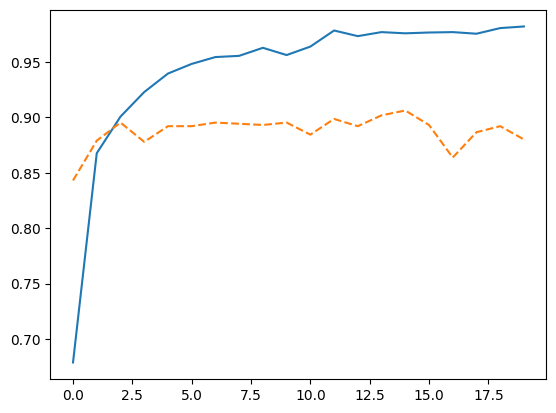

In [110]:
plt.plot(range(20), history.history['accuracy'])
plt.plot(range(20), history.history['val_accuracy'],'--')
plt.show()